In [311]:
from cyvcf2 import VCF
import subprocess
import os
import numpy as np
import pandas as pd
from tqdm import trange
from colorama import Fore
from functools import reduce

In [ ]:
# REFS:
# https://www.cell.com/ajhg/fulltext/S0002-9297(09)00020-2

In [ ]:
# TODO: missing genotypes check
# TODO: argparse
# TODO: generate test data
# TODO: asserts for ID, REF/ALT etc.
# TODO: refactor functions

In [431]:
mask = 'data/target.masked.vcf.gz'
imp = 'data/HRC.masked.vcf.gz'

In [527]:
def give_ns(gt_masked: np.array) -> np.array:
    """
    Action:
    Calculate total number of individuals
    for each actual genotype type.
    
    For more info:
    see ImputationQualityScore()
    """
    return np.array([sum(gt_masked == i) for i in range(3)])

def give_ms(prob_imp: np.array) -> np.array:
    """
    Action:
    Calculate sum of marginal probabilities
    for each imputed genotype type.
    
    For more info:
    see ImputationQualityScore()
    """
    return  reduce(lambda x, y : x + y, prob_imp)

def give_Po(geno_mask: np.array,
            geno_imp: np.array,
            prob_imp: np.array) -> float:
    """
    Action:
    Calculate Po (Concordance rate)*
    
    Note: In comparison with Concordance(...),
    this coefficient uses imputed probabilities
    instead of best guess genotypes
    
    For more info:
    see ImputationQualityScore()
    """
    prob_imp_max = np.array(list(map(lambda x : max(x), prob_imp)))
    return sum(prob_imp_max[geno_mask == geno_imp])/len(prob_imp_max)

def give_Pc(ms: np.array,
            ns: np.array) -> float:
    """
    Action:
    Calculate Po (Concordance rate)
    
    For more info:
    see ImputationQualityScore()
    """
    return np.dot(ns, ms)/sum(ns)**2

def ImputationQualityScore(geno_mask: np.array,
                           prob_imp: np.array,
                           Po :float) -> float:
    """
    Action: 
    Calculate IQS (imputation quality score)
    Formula - (Po - Pc)/(1 - Pc)
    
    Input:
    1) encoded masked genotypes {0, 1, 2}*
    1) encoded imputed genotypes {0, 1, 2}*
    1) imputed genotype probabilities [0-1]
    (FORMAT = GP)
    
    *Note:
    Counted allele - alternative
    
    References:
    https://doi.org/10.1371/journal.pone.0137601
    https://doi.org/10.1371/journal.pone.0009697
    """
    
    ns = give_ns(geno_mask)
    ms = give_ms(prob_imp)
    Pc = give_Pc(ns, ms)
    
    return round((Po - Pc)/(1 - Pc), 3)

In [528]:
def Rsquare(geno_mask: np.array,
            dasage_imp: np.array) -> float:
    """
    Action: 
    Calculate Squared Correlation coefficient
    between encoded genotypes and imputed dosages
    
    Input:
    1) encoded masked genotypes {0, 1, 2}*
    2) imputed dosages [0-2]

    *Note:
    Counted allele - alternative
    """
    return round(np.corrcoef(geno_mask, dasage_imp)[0,1]**2, 3)

In [529]:
def Concordance(geno_mask: np.array,
                geno_imp: np.array) -> float:
    """
    Action: 
    Calculate Concordance coefficient
    between encoded actual and imputed genotypes. 
    
    Input:
    1) encoded masked genotypes {0, 1, 2}*
    2) encoded imputed genotypes {0, 1, 2}*

    *Note:
    Counted allele - alternative
    """
    return round(sum(geno_mask == geno_imp)/len(geno_mask), 3)

In [530]:
NVARS = int(subprocess.run(f'zcat {imp} | grep -v "#" | cut -f1 | wc -l', shell=True, capture_output=True).stdout)
BAR_FORMAT = "{l_bar}%s{bar}%s{r_bar}" % (Fore.LIGHTRED_EX, Fore.RESET)

scores = pd.DataFrame(columns=['ID', 'AF', 'CR_GT', 'CR_GP', 'R2', 'IQS', 'DR2'])

for masked, imputed, _ in zip(VCF(mask),
                           VCF(imp),
                           trange(NVARS, bar_format=BAR_FORMAT)):
    ID = masked.ID
    AF = imputed.aaf
    if masked.call_rate != 1:
        print(f'Warning: Call rate of {ID} is not 1 -> We will skip it!')
        continue
    
    # Inputs: genotypes, imputation probabilities and dosages
    GT_masked = np.array(list(map(lambda x : x[0] + x[1], masked.genotypes)))
    GT_imputed = np.array(list(map(lambda x : x[0] + x[1], imputed.genotypes)))
    GP_imputed = imputed.format('GP')
    DS_imputed = np.squeeze(imputed.format('DS'))
    
    # Scores
    if imputed.INFO.get('DR2'):
        DR2 = round(imputed.INFO.get('DR2'), 3)
    CR_GT = Concordance(GT_masked, GT_imputed)
    CR_GP = give_Po(GT_masked, GT_imputed, GP_imputed)
    IQS = ImputationQualityScore(GT_masked, GP_imputed, CR_GP)
    R2 = Rsquare(GT_masked, DS_imputed)
    
    df_tmp = pd.DataFrame({'ID' : [ID],
                           'AF' : [AF],
                           'CR_GT' : [CR_GT],
                           'CR_GP' : [CR_GP],
                           'R2' : [R2],
                           'IQS' : [IQS],
                           'DR2' : [DR2]})
    
    scores = pd.concat([scores, df_tmp])   

100%|█████████▉| 23603/23604 [01:56<00:00, 202.03it/s]


In [484]:
len(GP_imputed)

247

In [485]:
sum(ns)

247

In [423]:
[sum(GT_masked == i) for i in range(2)]

[220, 27]

In [479]:
np.dot(ns, ms)

22638.138648986816

In [369]:
scores.to_csv('test.tsv', sep='\t', index=False)

<AxesSubplot:xlabel='IQS', ylabel='DR2'>

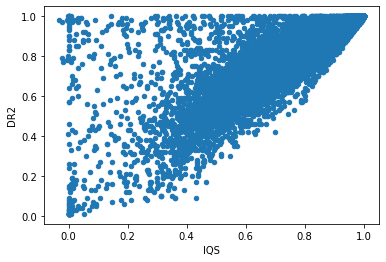

In [254]:
scores.plot.scatter(x='IQS', y='DR2')

<AxesSubplot:xlabel='AF', ylabel='CR_GP'>

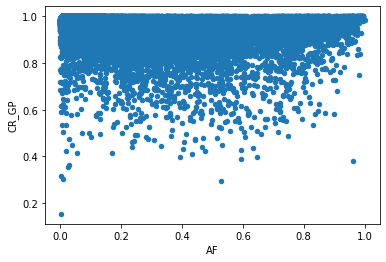

In [534]:
scores[scores.IQS > 0].plot.scatter(x='AF', y='CR_GP')

In [538]:
scores['AF_group'] = list(map(lambda af : '>0.05' if af > 0.05 else '0.01-0.05' if af < 0.05 and af > 0.01 else '<0.01', scores.AF))

In [540]:
import seaborn as sns

<AxesSubplot:xlabel='AF_group', ylabel='IQS'>

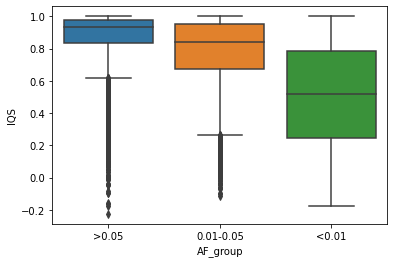

In [544]:
sns.boxplot(x='AF_group', y='IQS', data=scores)

<AxesSubplot:xlabel='AF_group', ylabel='CR_GP'>

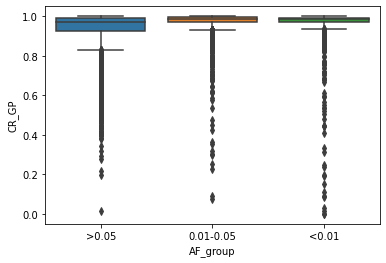

In [548]:
sns.boxplot(x='AF_group', y='CR_GP', data=scores)

In [550]:
reduce(lambda x, y: x + y, GP_imputed)

array([ 85.64   , 114.37999,  46.94   ], dtype=float32)

In [551]:
np.array([sum(GT_masked == i) for i in range(3)])

array([ 78, 119,  50])